# Notebook 1: Data exploration

In this notebook, we start to look at the data we are provided : food images, labels and bounding boxes.

We will build and demonstrate the tools we need for later use, but also discuss and understand how we need to treat the data in order to solve our problem.

In [1]:
import os
import json
from pathlib import Path

import pandas as pd
from skimage import io
import matplotlib.pyplot as plt

from torchvision.utils import make_grid
from torchvision.transforms.functional import to_tensor

from google.colab import drive


%matplotlib inline

## Loading the data

We chose to store the data on Google Drive and mount it in this environment.

In [2]:
DRIVE_PATH = Path('/') / 'content' / 'drive'

drive.mount(str(DRIVE_PATH))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


We resolve the paths of each data files we need.

In [3]:
BASE_PATH = DRIVE_PATH / 'My Drive' / 'Foodvisor' / 'home-assignment' / 'data'

IMG_DIR_PATH = BASE_PATH / 'assignment_imgs'
ANNOTATIONS_PATH = BASE_PATH / 'img_annotations.json'
LABEL_MAPPING_PATH = BASE_PATH / 'label_mapping.csv'

### Images 🎆

In [4]:
# Get all file names
img_fnames = [img for img in os.listdir(IMG_DIR_PATH) if img.endswith('.jpg') or img.endswith('.jpeg')]
len(img_fnames)

3000

We have got 3000 images. 

Let's load some of them to get an idea of their size. We don't load all of them because it's too expensive.

In [5]:
{io.imread(IMG_DIR_PATH / name).shape for name in img_fnames[:100]}

{(600, 600, 3), (600, 601, 3)}

It looks like they all are pretty much 600x600, which is good.

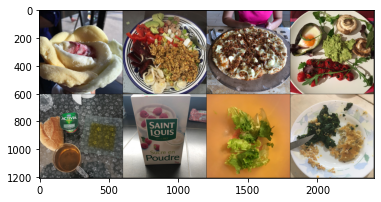

In [6]:
images = [io.imread(IMG_DIR_PATH / name) for name in img_fnames[:8]]
tensors = [to_tensor(img) for img in images]

plt.imshow(make_grid(tensors, nrow=4).numpy().transpose(1, 2, 0))
plt.show()

So, we have 3000 images of food. Most of them are 600x600 and are pictures of plates.

### Annotations and labels 🏷

For each image, we have annotations with some metadata.

In [7]:
with open(ANNOTATIONS_PATH) as f:
  annotations = json.load(f)

print(len(annotations))
list(annotations.items())[0]

3000


('ec2f4cece94a8b249c97277951d71396.jpeg',
 [{'box': [32, 54, 525, 541],
   'id': '939030726152341c154ba28629341da6_lab',
   'is_background': False},
  {'box': [140, 209, 175, 125],
   'id': '807c6457c23082f3b0a260984df7f8c5_lab',
   'is_background': False},
  {'box': [365, 281, 93, 105],
   'id': '807c6457c23082f3b0a260984df7f8c5_lab',
   'is_background': False},
  {'box': [263, 109, 108, 109],
   'id': '807c6457c23082f3b0a260984df7f8c5_lab',
   'is_background': False},
  {'box': [0, 0, 599, 64], 'id': 'main_lab', 'is_background': True}])

It appears that for each image, we have a list of label IDs associated with a bounding box and whether the food item is background or not.

Label IDs are not interpretable. We need to use the mapping to understand them:

In [8]:
df = pd.read_csv(LABEL_MAPPING_PATH)
df.head()

,labelling_id,labelling_name_fr,labelling_name_en
0,eca41ba7482963fb8c17c89adde3317e_lab,Bouteille d'eau (toutes marques),Bottle of water
1,ce629fd2f8994f6629d9c279639ab219_lab,Burrito,Burrito
2,539af0ef68c9d814332f605eaf559d44_lab,Club sandwich (le sandwich triangle),Club sandwich
3,d9a028f3e03cffb997f02c4a2b668854_lab,Fajitas,Fajitas
4,3b2ef2db1c497ce36ccac3717841e55a_lab,Galette au sarrasin (tous types),Buckwheat pancake


We convert it to a dict for simplicity of use since.

In [9]:
label_mapping = { 
    record['labelling_id']: record['labelling_name_en'] 
    for record in df.to_dict(orient='records')
}

print(len(label_mapping))
list(label_mapping.items())[0]

994


('eca41ba7482963fb8c17c89adde3317e_lab', 'Bottle of water')

## Drawing boxes

Now that we understand how our dataset is structured, we can use annotations to draw boxes and start to enjoy our dataset.

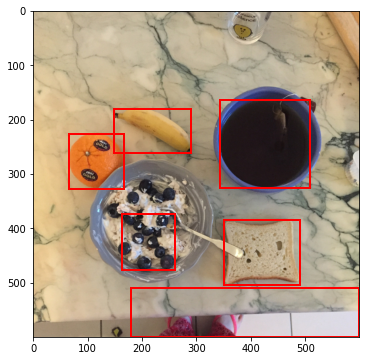

In [10]:
import matplotlib.patches as mpatches

img_name = img_fnames[9]
boxes = [meta['box'] for meta in annotations[img_name]]

fig, ax = plt.subplots(figsize=(10, 6))

ax.imshow(io.imread(IMG_DIR_PATH / img_name))

for box in boxes:
  x1, y1, w, h = box
  rect = mpatches.Rectangle((x1, y1), w, h, fill=False, edgecolor='red', linewidth=2)
  ax.add_patch(rect)

plt.show()

## Defining our training set

The last step here is to extract a training set out of our raw dataset. This means that we need to understand the use case and the problem we solve, in order to structure our data.

The problem statement says:
> We'll try to throw a warning if traces of tomatoes are present in the picture

This means that we need to not only detect an entire tomato, but any trace, this could be sauce, sliced tomatoes...

Let's look at the labels we are provided to understand what needs to be considered:

In [11]:
tomato_labels = [
 (label_id, label) 
 for label_id, label in label_mapping.items()
 if 'tomato' in label.lower()
]

print(len(tomato_labels))
tomato_labels

13


[('513535c5382eebf51dca54b46d570fe5_lab', 'Tomato juice'),
 ('939030726152341c154ba28629341da6_lab', 'Tomatoes'),
 ('9f2c42629209f86b2d5fbe152eb54803_lab', 'Cherry tomatoes'),
 ('4e884654d97603dedb7e3bd8991335d0_lab', 'Tomatoe whole'),
 ('f3c12eecb7abc706b032ad9a387e6f01_lab', 'Stuffed Tomatoes'),
 ('e306505b150e000f5e1b4f377ad688a0_lab', 'Stuffed tomatoes'),
 ('5816e75b36aa2708f126fe22abeda6ed_lab', 'Ravioli with tomato sauce'),
 ('4e2da86105869fc35c947c1b467a7f96_lab', 'Quiche provence w. tomato'),
 ('fb9547240ac8bb62713892d7e83e7ce2_lab', 'Sardine tomato sauce'),
 ('c262e42a627986076c07c4a194946a93_lab', 'Tomato Mozzarella'),
 ('a4abc986701f1759315bae54ba51198e_lab', 'Tomato sauce'),
 ('9de66567ece99ca7265921bf54cc6b9f_lab', 'Dried tomatoes'),
 ('7381c4a68441e0a72ab8c4783b5c1068_lab', 'Tomato soup')]

We have 13 labels containing the word tomato.

Since we are interested in allergies, any of them can be harmful for someone who cannot eat tomatoes. Then, these will be our positive label altogether.

In [12]:
tomato_ids = {label_id for label_id, _ in tomato_labels}

pruned_annotations = [
  (img, [meta for meta in metas if meta['id'] in tomato_ids])
  for img, metas in annotations.items()          
]

annotations_tomatoes = {img: metas for img, metas in pruned_annotations if metas}
len(annotations_tomatoes)

534

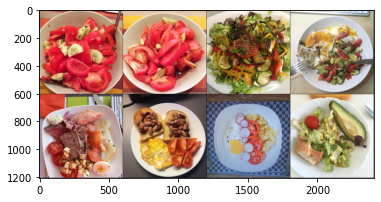

In [14]:
images = [io.imread(IMG_DIR_PATH / name) for name in list(annotations_tomatoes.keys())[:8]]
tensors = [to_tensor(img) for img in images]

plt.imshow(make_grid(tensors, nrow=4).numpy().transpose(1, 2, 0))
plt.show()

This is nice, we see tomatoes.

⚠️ We also notice that the classes are pretty imbalanced (534 positive / 3000). We will deal with this later on.

From now on, for the sake of the exercise, we decide to discard all other labels and only focus on the one we extracted above. We will still keep track of the bounding boxes for visualisation, but not for training.

To finalize, we export all of this in a Pytorch `Dataset` class that we will use later on: `tomatoes_dataset.py`.